In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from geopack import geopack
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats

#sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/') #MAc
#sys.path.append('/home/ryuho/anaconda3/envs/smrai_env') #Laptop
sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [2]:
NH_path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5min.dat' #Server
SH_path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5minss.dat' #Server


def open_and_format(file_path):
    with open (file_path) as f:
        rectype = np.dtype(np.float32)
        reppu_data = np.fromfile(f, rectype) #size = 109,900,800
    mhd_data = pd.read_csv('mhd_dates.csv')
    expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
            for start, end in zip(mhd_data['start'], mhd_data['end'])]) 
    data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 
    return data_reshaped, expanded_dt

NH_reshaped, NH_dt = open_and_format(NH_path)
SH_reshaped, SH_dt = open_and_format(SH_path)

In [263]:

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in NH_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'NH_current': (['dt', 'lat', 'lon'], NH_reshaped.reshape(-1, 30, 80)),
                'SH_current': (['dt', 'lat', 'lon'], SH_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add current and units
ds['NH_current'].attrs['units'] = 'mA/m^2'
ds['SH_current'].attrs['units'] = 'mA/m^2'
ds['NH_current'] = ds['NH_current'] * 1e6 #convert to mA/m^2
ds['SH_current'] = ds['SH_current'] * 1e6 #convert to mA/m^2


#diff
ds['diff'] = np.abs(ds['NH_current']) - np.abs(ds['SH_current'])
ds


<xarray.Dataset> Size: 1GB
Dimensions:     (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt          (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat         (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon         (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    NH_current  (dt, lat, lon) float32 440MB 0.0 0.0 0.0 ... 0.1782 0.1768
    SH_current  (dt, lat, lon) float32 440MB 0.01009 0.01013 0.01018 ... 0.0 0.0
    diff        (dt, lat, lon) float32 440MB -0.01009 -0.01013 ... 0.1782 0.1768

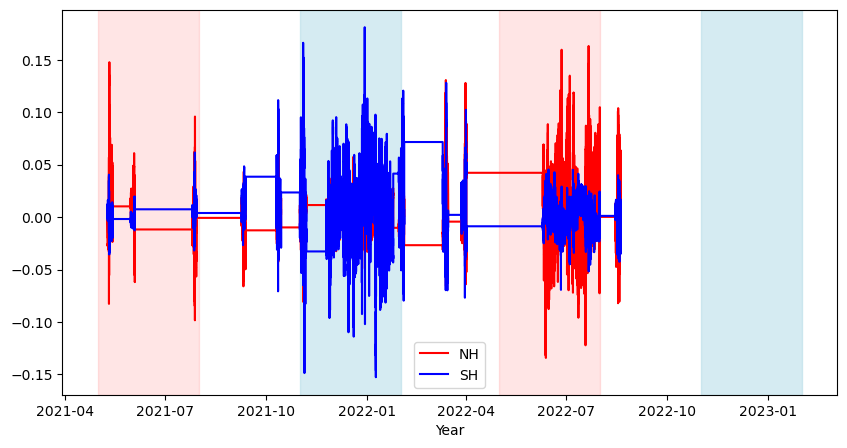

In [272]:
def plot_bartels(ds):
    ds = ds.copy()
    #ds = ds.sortby('dt')
    #ds = ds.resample(dt='1D').mean()

    jpar_NH = ds['NH_current'].values.mean(axis=(1,2)).flatten()
    jpar_SH = ds['SH_current'].values.mean(axis=(1,2)).flatten()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(x=dt, y=jpar_NH, label='NH', color='red',drawstyle='steps-pre')
    sns.lineplot(x=dt, y=jpar_SH, label='SH', color='blue',drawstyle='steps-pre')

    #add light blue shape between november and january for all years
    nov = pd.Timestamp('11-01')
    jan = pd.Timestamp('01-01')
    for i in range(2021, 2023):
        ax.axvspan(pd.Timestamp(f'{i}-11-01'), pd.Timestamp(f'{i+1}-02-01'), color='lightblue', alpha=0.5)

    #may = pd.Timestamp('05-01')
    #jul = pd.Timestamp('07-01')
    for i in range(2021, 2023):
        ax.axvspan(pd.Timestamp(f'{i}-05-01'), pd.Timestamp(f'{i}-08-01'), color='red', alpha=0.1)

    plt.xlabel('Year')

plot_bartels(ds)

In [4]:
NH_current = ds['NH_current'].values.flatten()
SH_current = ds['SH_current'].values.flatten()

NH_current_sample = NH_current[np.random.choice(NH_current.shape[0], 10000, replace=False)]
SH_current_sample = SH_current[np.random.choice(SH_current.shape[0], 10000, replace=False)]

In [83]:
#add to df then melt to plot with category of NH SH
df = pd.DataFrame({'current': np.concatenate([NH_current, SH_current]),
                   'Hemisphere': ['NH']*NH_current.shape[0] + ['SH']*SH_current.shape[0]})
df = df.melt(value_vars=['current'], id_vars=['Hemisphere'])
df

,Hemisphere,variable,value
0,NH,current,0.0
1,NH,current,0.0
2,NH,current,0.0
3,NH,current,0.0
4,NH,current,0.0
...,...,...,...
219801595,SH,current,0.0
219801596,SH,current,0.0
219801597,SH,current,0.0
219801598,SH,current,0.0


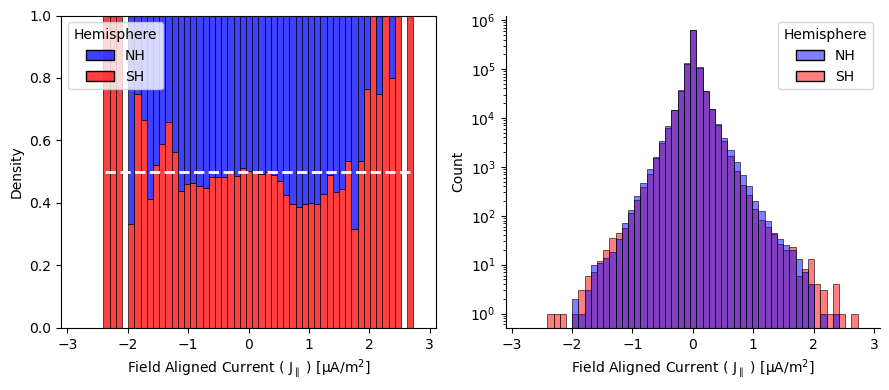

In [34]:
fig, ax = plt.subplots(1,2, figsize=(9, 4))
sns.histplot(data=df, x='value', hue='Hemisphere', bins = 50, ax=ax[0], multiple='fill', element='bars', palette=['blue', 'red'])
ax[0].set_xlim(-3.1, 3.1)
ma_unit = r'$\mathrm{\mu}$A/m$^2$'
jpar = r'J$_{\parallel}$'
ax[0].set_xlabel(f'Field Aligned Current ( {jpar} ) [{ma_unit}]')
ax[0].set_ylabel('Density')
ax[0].axhline(y=0.5, color='white', linestyle='--', linewidth=2)

sns.histplot(data=df, x='value', hue='Hemisphere', bins = 50, ax=ax[1], multiple='layer', element='bars', palette=['blue', 'red'])
ax[1].set_yscale('log')
ax[1].set_xlabel(f'Field Aligned Current ( {jpar} ) [{ma_unit}]')
ax[1].set_xlim(-3.1, 3.1)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig('REPPU_NH_SH_current_asymmetry_hist_full.png', dpi=500)

In [84]:
ds['diff'].values.mean(axis=0).shape

(30, 80)

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_58944/4274620966.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18,


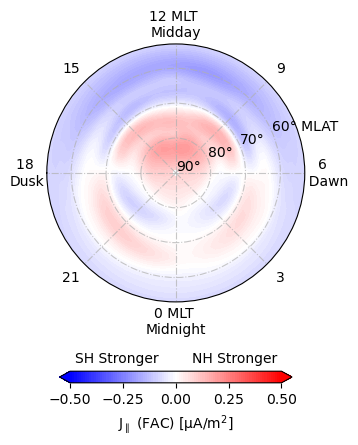

In [94]:
fac = ds['diff'].values.mean(axis=0)

#fac = fac.reshape(24, 50).T # reshape and transpose
#fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 80) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(53, 89, 30) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{dt}", pad=10, fontsize=11.5)

#add text above colorbar
ax.text(0.73, -0.22, 'NH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.27, -0.22, 'SH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18, 
             ticks=[-.5, -.25, 0, 0.25, 0.5], 
             orientation='horizontal')

plt.savefig('REPPU_NH_SH_current_asymmetry_radar.png', dpi=500, bbox_inches='tight')

In [308]:
#import 2004 to 2006 data
df_open = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro2_5min_2004_2007.csv')
#df = df.groupby(['Timestamp_1hr_omni']).mean().reset_index()
#rename Timestamp 1hr omni to dt
df = df_open.rename(columns={'Timestamp_1min_omni': 'dt'})
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt')
df = df.resample('10min').mean(numeric_only=True)
df = df.dropna()
df = df[['BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density', 'tilt_angle',]]
df.isnull().sum()
ds = df.to_xarray()
ds

<xarray.Dataset> Size: 10MB
Dimensions:         (dt: 203835)
Coordinates:
  * dt              (dt) datetime64[ns] 2MB 2004-01-01 ... 2007-12-31T23:50:00
Data variables:
    BY_GSE          (dt) float64 2MB 2.635 6.72 5.92 5.09 ... 2.95 3.95 4.045
    BZ_GSE          (dt) float64 2MB 8.835 1.825 -0.365 ... -1.655 1.04 1.77
    flow_speed      (dt) float64 2MB 528.5 523.5 523.0 ... 345.0 350.5 352.5
    proton_density  (dt) float64 2MB 6.635 7.205 7.25 6.14 ... 6.965 6.73 6.868
    tilt_angle      (dt) float64 2MB -0.4518 -0.4594 -0.4668 ... -0.4351 -0.4426

In [309]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, nan_count, np.round(nan_ratio, 2)

nan_count(ds, 'tilt_angle')

(203835, 0, 0.0)

In [310]:
def load_esn(ds):

   ds = ds.copy()

   def load_and_prediction(ds, hemi):

      ds = ds.copy()

      with open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_current_{hemi}_ID8.pkl', 'rb') as f:
         model = pickle.load(f)

      pca_reload = pickle.load(open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_current_{hemi}_pca_ID8.pkl','rb'))

      prediction_arr = ds.to_array().values.T
      prediction = model.predict(prediction_arr)

      #return prediction.shape

      prediction_original = pca_reload.inverse_transform(prediction)
      prediction_original = prediction_original.reshape(-1, 30, 80)

      return prediction_original

   nh_jpar = load_and_prediction(ds, 'NH')
   sh_jpar = load_and_prediction(ds, 'SH')

   ds['jPar_NH'] = (('dt', 'lat', 'lon'), nh_jpar)
   ds['jPar_SH'] = (('dt', 'lat', 'lon'), sh_jpar)
   ds['jPar_diff'] = ds['jPar_NH'] - ds['jPar_SH']

   def calculate_bartels(ds):
      start_date = pd.Timestamp('1832-02-08')
      days_since_start = (ds['dt'].values - np.datetime64(start_date)) / np.timedelta64(1, 'D')
      bartels = np.ceil(days_since_start / 27).astype(int)
      
      return bartels

   ds['bartels'] = calculate_bartels(ds)

   return ds

ds_bartels = load_esn(ds)
ds_bartels

<xarray.Dataset> Size: 12GB
Dimensions:         (dt: 203835, lat: 30, lon: 80, bartels: 203835)
Coordinates:
  * dt              (dt) datetime64[ns] 2MB 2004-01-01 ... 2007-12-31T23:50:00
  * bartels         (bartels) int64 2MB 2326 2326 2326 2326 ... 2380 2380 2380
Dimensions without coordinates: lat, lon
Data variables:
    BY_GSE          (dt) float64 2MB 2.635 6.72 5.92 5.09 ... 2.95 3.95 4.045
    BZ_GSE          (dt) float64 2MB 8.835 1.825 -0.365 ... -1.655 1.04 1.77
    flow_speed      (dt) float64 2MB 528.5 523.5 523.0 ... 345.0 350.5 352.5
    proton_density  (dt) float64 2MB 6.635 7.205 7.25 6.14 ... 6.965 6.73 6.868
    tilt_angle      (dt) float64 2MB -0.4518 -0.4594 -0.4668 ... -0.4351 -0.4426
    jPar_NH         (dt, lat, lon) float64 4GB 2.928e-07 5.85e-08 ... -0.05735
    jPar_SH         (dt, lat, lon) float64 4GB 0.1573 0.1561 0.1549 ... 0.0 0.0
    jPar_diff       (dt, lat, lon) float64 4GB -0.1573 -0.1561 ... -0.05735

(array([3.00000000e+00, 1.00000000e+00, 4.00000000e+00, 8.00000000e+00,
        9.00000000e+00, 1.00000000e+01, 1.00000000e+01, 1.40000000e+01,
        1.30000000e+01, 1.40000000e+01, 9.00000000e+00, 1.10000000e+01,
        8.00000000e+00, 1.20000000e+01, 2.30000000e+01, 3.40000000e+01,
        4.00000000e+01, 4.30000000e+01, 4.40000000e+01, 5.30000000e+01,
        7.10000000e+01, 1.03000000e+02, 1.25000000e+02, 1.53000000e+02,
        2.67000000e+02, 3.43000000e+02, 5.02000000e+02, 6.48000000e+02,
        1.23100000e+03, 2.72300000e+03, 7.33900000e+03, 4.30480000e+04,
        8.19917300e+06, 4.79864815e+08, 1.03188700e+06, 3.30950000e+04,
        8.82200000e+03, 4.08200000e+03, 2.30900000e+03, 1.18300000e+03,
        5.82000000e+02, 3.82000000e+02, 2.42000000e+02, 1.71000000e+02,
        1.07000000e+02, 7.60000000e+01, 6.50000000e+01, 4.40000000e+01,
        3.00000000e+01, 1.90000000e+01]),
 array([-18.31500352, -17.76582107, -17.21663863, -16.66745618,
        -16.11827373, -15.5690

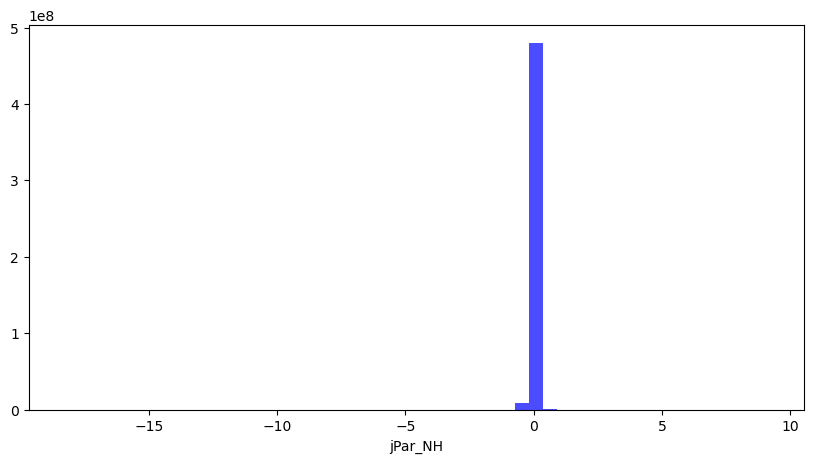

In [311]:
fig, ax = plt.subplots(figsize=(10, 5))
ds_bartels['jPar_NH'].plot.hist(ax=ax, bins=50, color='blue', alpha=0.7)

In [303]:
def clock_angle(By, Bz):
    angle = np.rad2deg(np.arctan2(By, Bz))
    np.where(angle < 0, angle + 360, angle)
    #angle = np.deg2rad(angle)
    return angle


def dayside_reconnection_rate(v_sw, By, Bz):
    By = By * 1e-9 #nT to T
    Bz = Bz * 1e-9
    v_sw = v_sw * 1e3 #km/s to m/s
    l_0 = 6371 * 1e3 * 3.8 #3.8 R_E in m

    Byz = np.sqrt(By**2 + Bz**2)
    L_eff = l_0 * (v_sw/(4*1e5))**(1/3)
    theta = clock_angle(By, Bz)
    Phi_D = L_eff * v_sw * Byz * np.sin(theta/2)**(9/4)
    #return np.log10(Phi_D + 1) 
    return Phi_D / 1e3

ds_bartels['Phi_D'] = dayside_reconnection_rate(ds_bartels['flow_speed'], ds_bartels['BY_GSE'], ds_bartels['BZ_GSE'])
ds_bartels

<xarray.Dataset> Size: 3MB
Dimensions:         (dt: 48, lat: 30, lon: 80, bartels: 48)
Coordinates:
  * dt              (dt) datetime64[ns] 384B 2004-01-31 ... 2007-12-31
  * bartels         (bartels) int64 384B 2327 2328 2329 2330 ... 2378 2379 2380
Dimensions without coordinates: lat, lon
Data variables:
    BY_GSE          (dt) float64 384B 0.1782 -0.2801 0.2789 ... -0.2099 -0.5019
    BZ_GSE          (dt) float64 384B -0.4906 0.0002392 ... 0.05316 0.1026
    flow_speed      (dt) float64 384B 545.3 495.5 495.9 ... 429.1 442.5 437.5
    proton_density  (dt) float64 384B 5.079 3.691 3.921 ... 5.966 5.779 6.134
    tilt_angle      (dt) float64 384B -0.3591 -0.2249 ... -0.321 -0.3969
    jPar_NH         (dt, lat, lon) float64 922kB 1.54e-07 -8.977e-08 ... 0.01458
    jPar_SH         (dt, lat, lon) float64 922kB 0.02094 0.02001 ... 0.0 0.0
    jPar_diff       (dt, lat, lon) float64 922kB -0.02094 -0.02001 ... 0.01458
    Phi_D           (dt) float64 384B nan nan nan 0.0006069 ... nan nan nan

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_58944/858761262.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18,


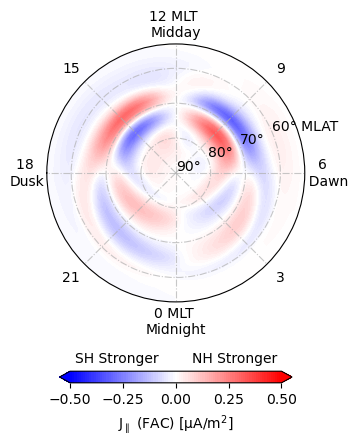

In [304]:
fac = ds_bartels['jPar_diff'].values.mean(axis=0)

#fac = fac.reshape(24, 50).T # reshape and transpose
#fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 80) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(53, 89, 30) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{dt}", pad=10, fontsize=11.5)

#add text above colorbar
ax.text(0.73, -0.22, 'NH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.27, -0.22, 'SH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18, 
             ticks=[-.5, -.25, 0, 0.25, 0.5], 
             orientation='horizontal')

#plt.savefig('SMRAI2_NH_SH_current_asymmetry_radar.png', dpi=500, bbox_inches='tight')

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_58944/3722587284.py:31: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('FAC (J$_\parallel$) [µA/m$^2$]')


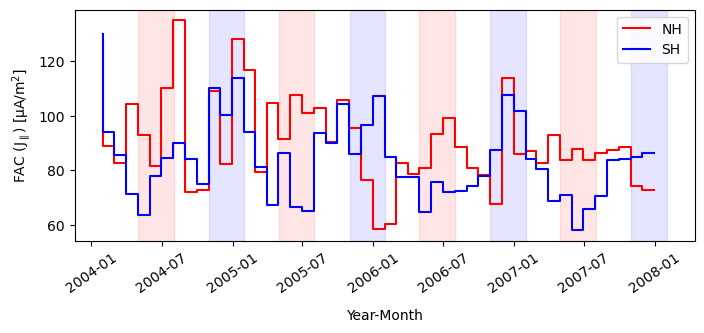

In [307]:
#bartels = ds_bartels['bartels'].values.flatten()
dt = ds_bartels['dt'].values.flatten()
jpar_NH = ds_bartels['jPar_NH'].values
jpar_NH = np.abs(jpar_NH).sum(axis=(1,2)).flatten()
jpar_SH = ds_bartels['jPar_SH'].values
jpar_SH = np.abs(jpar_SH).sum(axis=(1,2)).flatten()
#phi_d = ds_bartels['Phi_D'].values.flatten()

F107 = df_open['F10.7'].values

fig, ax = plt.subplots(1, 1, figsize=(8, 3))


sns.lineplot(x=dt, y=jpar_NH, label='NH', color='red',drawstyle='steps-pre')
sns.lineplot(x=dt, y=jpar_SH, label='SH', color='blue',drawstyle='steps-pre')

#add light blue shape between november and january for all years
nov = pd.Timestamp('11-01')
jan = pd.Timestamp('01-01')
for i in range(2004, 2008):
    ax.axvspan(pd.Timestamp(f'{i}-11-01'), pd.Timestamp(f'{i+1}-02-01'), color='blue', alpha=0.1)

#may = pd.Timestamp('05-01')
#jul = pd.Timestamp('07-01')
for i in range(2004, 2008):
    ax.axvspan(pd.Timestamp(f'{i}-05-01'), pd.Timestamp(f'{i}-08-01'), color='red', alpha=0.1)

plt.xlabel('Year-Month', labelpad=10)
#rotate x-axis labels
plt.xticks(rotation=35)
plt.ylabel('FAC (J$_\parallel$) [µA/m$^2$]')
plt.savefig('SMRAI2_NH_SH_current_asymmetry_bartels.png', dpi=500, bbox_inches='tight')